In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

from cli       import NumpyEncoder
from string    import ascii_lowercase
from tqdm.auto import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable


try:
    plt.style.reload_library()
    plt.style.use('science')
except OSError:
    print('Loading science style for Matplotlib failed, reverting to default style.')
    
np.random.seed(827)

In [2]:
raw_data_dir  = '../data/abm-data/'
processed_dir = '../data/processed-emulator-inputs/'
figures_dir   = '../figures/'

data      = {}
all_dicts = {}

# Processing SIR modeling outputs

### Loading parameters/process variables


In [3]:
# Specify parameters that are not held constant over different
# ABM runs
sir_params_varying = [
    'ptrans',
    'death_rate',
    'pcure',
    'p_infected_initial_log10',
    'pdoctor_log10'
]

params_to_be_log = [
    'ptrans',
    'death_rate',
    'pcure',  
]

# Some parameters should be log transformed first.
data['params'] = pd.DataFrame(pickle.load(open(raw_data_dir + f'/sir/input_dicts.pkl','rb')))

for param in params_to_be_log:
    data['params'][param + '_log10'] = np.log10(data['params'][param])
    data['params'].drop(param, inplace=True, axis=1)
    
sir_params_varying = [
    'ptrans_log10',
    'death_rate_log10',
    'pcure_log10',
    'p_infected_initial_log10',
    'pdoctor_log10'
]


In [4]:
# If we don't want to load all the blocks into memory, use this to thin out some of the series
n_repeats_kept      = 200
indices_repeat_kept = np.random.choice(np.arange(len(data['params'])), size=n_repeats_kept)
data['params'] = data['params'][sir_params_varying].values[indices_repeat_kept]


### Loading SIR cell states into blocks

This step may take large amounts of memory. For an SIR simulation with spatial domain of size $60\times20$ cells and $80$ timesteps, peak RAM usage reached 40 GB.

In [5]:
n_blocks = len([x for x in os.listdir(raw_data_dir + '/sir/') if 'sir_states' in x])
pieces   = [pickle.load(open(raw_data_dir + f'/sir/sir_states_{i}.pkl','rb')) for i in trange(n_blocks)]

  0%|          | 0/78 [00:00<?, ?it/s]

In [6]:
for sn in ['all_states']:
    data[sn] = np.concatenate([x[sn][...,1] for x in pieces], axis=0)
    data[sn] = data[sn][indices_repeat_kept]
    
data['static']     = np.argmax(data['all_states'], axis=1)

### Splitting data into blocks

In [7]:
n_repeats, T, width, height = data['all_states'].shape

In [8]:
# Width is 60, height is 20
n_cols = 12
n_rows = 4

In [9]:
data['all_states'].shape

(200, 80, 60, 20)

In [10]:
subblocks = [np.split(b, n_rows, axis=3) for b in np.split(data['all_states'], n_cols, axis=2)]
subblocks = sum(subblocks, start=[])
subblocks = [s.sum(axis=(2,3)) for s in subblocks]

x_coords = np.arange(0,width,width/n_cols) + (width/n_cols)/2
y_coords = np.arange(0,height,height/n_rows) + (height/n_rows)/2

coords   = [[(x,y) for y in y_coords] for x in x_coords]
spatial_coords_flat = np.asarray(sum(coords, start=[]))
spatial_len, _      = spatial_coords_flat.shape

blocks = np.asarray(subblocks).swapaxes(1,2)
block_sum = blocks.sum(axis=0)
block_argmax = np.argmax(block_sum, axis=0)

In [11]:
_, n_params = data['params'].shape

### Declaring variable dimensions

In [12]:
dimensions = {
    'space1'         : spatial_coords_flat[:,0],
    'space2'         : spatial_coords_flat[:,1],
    'spatial_index'  : np.arange(len(spatial_coords_flat)),
    'time'           : np.arange(T),
    'params'         : sir_params_varying,
    'repeats'        : np.arange(n_repeats)
}

### Creating train / test indices

In [13]:
np.random.seed(827)
half_n_repeats = int(n_repeats_kept/2)
test_indices  = np.random.choice(np.arange(n_repeats_kept), half_n_repeats)
train_indices = np.asarray(list(set(np.arange(n_repeats_kept)) - set(test_indices)))
print(f'{len(train_indices)} points supplied for training:', train_indices[0:10])

127 points supplied for training: [ 0  1  2  3  5  7  9 10 12 13]


### Packaging into JSON file

In [14]:
json_dict = {
    'space+time+process_response': blocks,
    'time+process_response'      : block_sum,
    'process'                    : data['params'],
    'process_response'           : block_argmax,
    'space'                      : spatial_coords_flat,
    'spatial_index'              : np.arange(len(spatial_coords_flat)),
    'time'                       : np.arange(T),
    'process_names'              : sir_params_varying,
    'repeats'                    : np.arange(n_repeats),
    'train_indices'              : train_indices,
    'test_indices'               : test_indices,
    }


with open(f'{processed_dir}sir.json', 'w') as dst:
    json.dump(json_dict, dst, cls=NumpyEncoder)
    
all_dicts['sir'] = json_dict

### Generating plot of SIR states

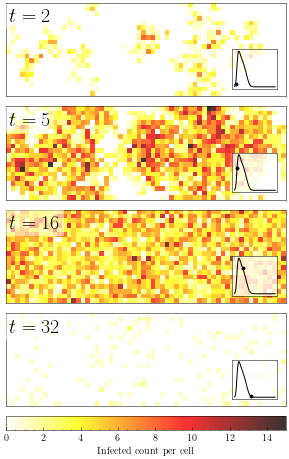

In [15]:
save_fig = False

x = data['all_states']
timesteps = [2, 5, 16, 32]
fig, axes = plt.subplots(len(timesteps),
                         figsize=(4,1.6*len(timesteps)),
                         constrained_layout=True)
axes = axes.ravel()

sim_idx = 50

cmap = 'hot_r'

for i, t in enumerate(timesteps):
    
    plt.sca(axes[i])
    img = plt.imshow(x[sim_idx, t, :, :].T, cmap=cmap, vmin=0, vmax=15, alpha=0.80)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    axin1 = axes[i].inset_axes([0.81, 0.08, 0.16, 0.42], transform=axes[i].transAxes)
    axin1.plot(block_sum[:, sim_idx], color='k')
    axin1.scatter([t], [block_sum[t, sim_idx]], color='k', zorder=2, s=8)
    axin1.set_xticks([])
    axin1.set_yticks([])
    axin1.patch.set_alpha(0.75)

    plt.text(0.01, 0.95, f'$t={t}$', transform=axes[i].transAxes,
             fontsize=20, ha='left',va='top',
             bbox={'facecolor':'white', 'edgecolor':'none', 'alpha':0.5})
    
    if i+1 == len(timesteps):
        cb = fig.colorbar(img, ax=axes.ravel().tolist(),
                    orientation='horizontal', label='Infected count per cell',
                    pad=0.02)
if save_fig:
    plt.savefig('../figures/sir-states.png', dpi=500)

In [16]:
pd.Series(index=sir_params_varying, data=data['params'][train_indices[30]])

ptrans_log10               -0.795826
death_rate_log10           -1.000000
pcure_log10                -0.090444
p_infected_initial_log10   -3.600000
pdoctor_log10              -4.000000
dtype: float64

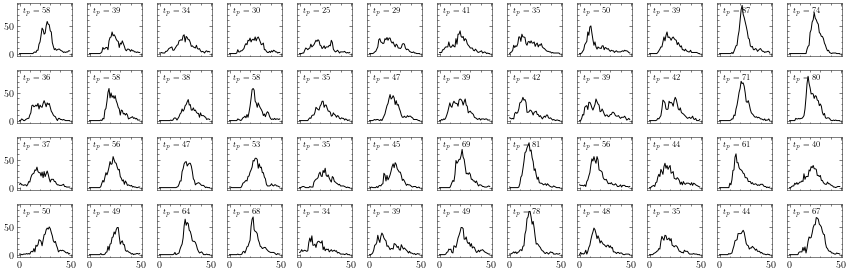

In [17]:
fig, axes = plt.subplots(4,12, figsize=(12,4), sharex=True, sharey=True)
axes      = axes.ravel(order='F')

for i, ax in enumerate(axes):
    peak = np.max(blocks[i,0:50,30])
    ax.plot(blocks[i,0:50,30], color='k')
    ax.text(0.1,0.8, f'$t_p={peak}$', transform=ax.transAxes, fontsize=8)
    
plt.tight_layout()
plt.savefig('../figures/sir-spatial.png', dpi=400)

# Processing Couzin modeling outputs

In [31]:
# Artificial noise added to Couzin model outputs, if necessary
resp_noise = 0.0

# This needs to be specified ahead of time - it's the
# number of spatial units 
n_blocks = 27
n_train  = 90

dir_df = pd.read_csv(f'{raw_data_dir}/couzin/couzin_spacetime_groupdir_conserved2.csv', index_col=0)
T = dir_df.shape[-1]

n_repeats = int(dir_df.shape[0] / n_blocks)

n_test   = n_repeats - n_train
all_indices   = set(np.arange(n_repeats))
train_indices = list(set(np.random.choice(np.arange(n_repeats), size=n_train, replace=False)))
test_indices  = list(all_indices - set(train_indices))

rho_df = pd.read_csv(f'{raw_data_dir}/couzin/couzin_spacetime_grouprho_conserved2.csv', index_col=0)

blocks = dir_df.values.reshape([n_repeats, n_blocks, 100])
blocks = blocks.swapaxes(0,1).swapaxes(1,2) 
blocks = blocks + np.random.randn(*blocks.shape)*resp_noise

timesteps = np.arange(T)

# Picking the process model response as the sum of the angular momenta over all time and space
param_df            = pd.read_csv(f'{raw_data_dir}/couzin/couzin_spacetime_paramkey_conserved2.csv', index_col=0)
spatial_coords_flat = param_df[['x','y','z']].drop_duplicates(inplace=False).values
param_vals          =  param_df[['r_o','r_a']].drop_duplicates(inplace=False).values
block_sum           = blocks.sum(axis=0)
block_mean_all_axes = blocks.mean(axis=(0,1))

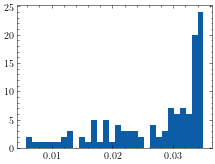

In [32]:
plt.hist(block_mean_all_axes.ravel(), bins=30);

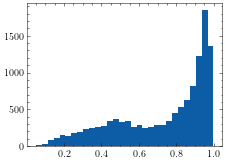

In [33]:
plt.hist(block_sum.ravel(), bins=30);

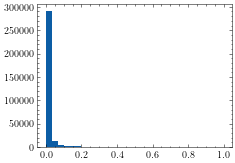

In [34]:
plt.hist(blocks.ravel(), bins=30);

### Generating plot of Couzin time+process variable

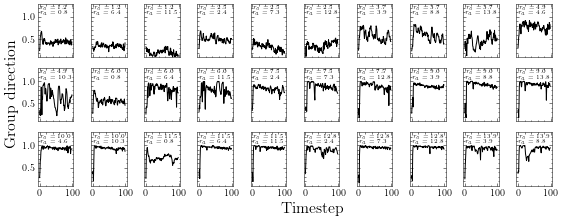

In [19]:
fig,axes = plt.subplots(3,10, figsize=(8,3),sharex=True, sharey=True)
axes     = axes.ravel()

n_timesteps, n_series = block_sum.shape

for i in range(30):
    plt.sca(axes[i])
    ro,ra=param_vals[i*4]
    axes[i].plot(block_sum[:,i*4], color='k')
    plt.ylim([0.1,1.3])
    axes[i].text(0.07, 0.9, f"$r_o={ro:.1f}$", transform=axes[i].transAxes, fontsize=6)
    axes[i].text(0.05, 0.8, f"$r_a={ra:.1f}$", transform=axes[i].transAxes, fontsize=6)
    
    #for j in range(n_series):
    #    axes[i].plot(block_sum[:,j], color='0.2', alpha=0.05)
        
    if i == 10:
        axes[i].set_ylabel('Group direction', fontsize=16)
        
plt.tight_layout()
plt.suptitle('Timestep', y=0.03, fontsize=16, ha='left')
plt.savefig('../figures/couzin-tp.png', dpi=400)

In [20]:
# Perturbing the coordinate locations to help break symmetries in coordinates
coords_noise = 1.0
spatial_coords_flat = spatial_coords_flat + np.random.randn(*spatial_coords_flat.shape) * coords_noise

In [21]:
json_dict = {
    'space+time+process_response': blocks,
    'time+process_response'      : block_sum,
    'process'                    : param_vals,
    'process_response'           : block_mean_all_axes,
    'space'                      : spatial_coords_flat,
    'spatial_index'              : np.arange(len(spatial_coords_flat)),
    'time'                       : timesteps,
    'process_names'              : ['r_o','r_a'],
    'repeats'                    : np.arange(n_repeats),
    'train_indices'              : train_indices,
    'test_indices'               : test_indices,
    }
        
with open(f'{processed_dir}couzin.json', 'w') as dst:
    json.dump(json_dict, dst, cls=NumpyEncoder)
    
all_dicts['couzin'] = json_dict

### Packaging Kauffman network data

In [22]:
n_train = 50

kauffman_param_df = pd.read_csv(f'{raw_data_dir}/kauffman/kauffman_tseries_params.csv')
kauffman_ts_df    = pd.read_csv(f'{raw_data_dir}/kauffman/kauffman_tseries.csv')
n_repeats_kauffman, T_kauffman = kauffman_ts_df.shape
kauffman_timesteps = np.arange(T_kauffman)

all_indices   = set(np.arange(n_repeats_kauffman))
train_indices = list(set(np.random.choice(np.arange(n_repeats_kauffman), size=n_train, replace=False)))
test_indices  = list(all_indices - set(train_indices))

In [23]:
json_dict = {
    'time+process_response'      : kauffman_ts_df.values.T,
    'process'                    : kauffman_param_df.values,
    'process_response'           : kauffman_ts_df.mean(axis=1).values,
    'time'                       : kauffman_timesteps,
    'process_names'              : ['p', 'k'],
    'repeats'                    : np.arange(n_repeats_kauffman),
    'train_indices'              : train_indices,
    'test_indices'               : test_indices,
    }

with open(f'{processed_dir}kauffman.json', 'w') as dst:
    json.dump(json_dict, dst, cls=NumpyEncoder)
    
all_dicts['kauffman'] = json_dict

## Dataset sparsity printout checks

In [24]:
resp_types = [
    'space+time+process_response',
    'time+process_response',
    'process_response'
]

for name, jsd in all_dicts.items():
    print(f'\nSparsity for {name} model outputs:')
    for resp in resp_types:
        if resp in jsd.keys():
            sparsity = (jsd[resp] == 0.).mean()
            print(f'\t{resp.ljust(30)} sparsity: {sparsity:.2f}, N={str(jsd[resp].size).ljust(6)}  shape: {jsd[resp].shape}')


Sparsity for sir model outputs:
	space+time+process_response    sparsity: 0.60, N=768000  shape: (48, 80, 200)
	time+process_response          sparsity: 0.39, N=16000   shape: (80, 200)
	process_response               sparsity: 0.22, N=200     shape: (200,)

Sparsity for couzin model outputs:
	space+time+process_response    sparsity: 0.77, N=326700  shape: (27, 100, 121)
	time+process_response          sparsity: 0.00, N=12100   shape: (100, 121)
	process_response               sparsity: 0.00, N=121     shape: (121,)

Sparsity for kauffman model outputs:
	time+process_response          sparsity: 0.46, N=4000    shape: (40, 100)
	process_response               sparsity: 0.05, N=100     shape: (100,)


## Making plots of datasets

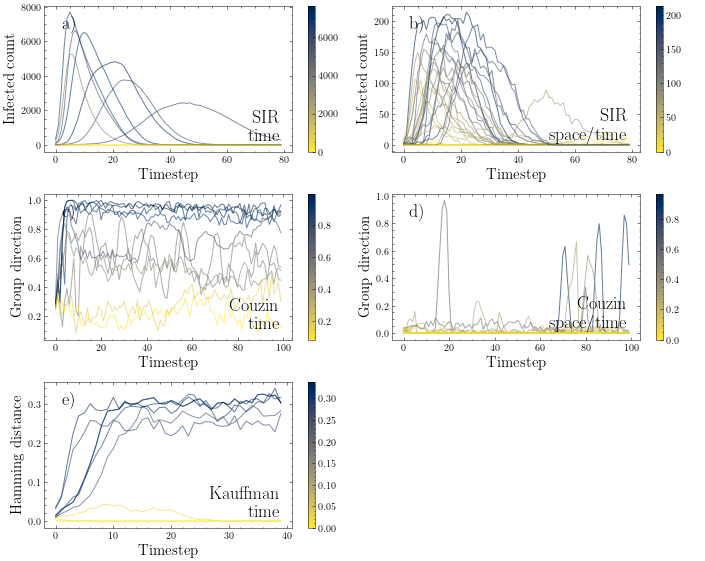

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(10,8))

shown_per_str = {
    'time+process_response':10,
    'space+time+process_response':30
    }

np.random.seed(827)

cmap    = 'cividis_r'
cmap_fn = plt.cm.cividis_r
dataset_names = ['sir', 'couzin', 'kauffman']
fancy_ds_names = ['SIR\ntime','SIR\nspace/time',
                  'Couzin\ntime','Couzin\nspace/time',
                  'Kauffman\ntime']
time_series = json_dict

ylabels = ['Infected count', 'Group direction', 'Hamming distance']
str_ctr = 0
for k, dataset in enumerate(dataset_names):
    
    time_series = all_dicts[dataset]

    for j, string in enumerate(['time+process_response', 'space+time+process_response']):
        
        plt.sca(axes[k,j])
        if 'space' in string and 'space' not in time_series.keys():
            axes[k,j].axis('off')
            continue
            
        y_for_plot = time_series[string]

        if string == 'time+process_response':
            y_for_plot = y_for_plot.T
        else:
            y_for_plot = y_for_plot.swapaxes(1,2)
            y_for_plot = y_for_plot.reshape(-1, y_for_plot.shape[-1])
        
        indices_shown = np.random.choice(np.arange(len(y_for_plot)), shown_per_str[string])
        y_for_plot = y_for_plot[indices_shown]

        colors = y_for_plot.mean(axis=1)
        colors = colors - colors.min()
        colors = colors/colors.max()
        colors = cmap_fn(colors)

        for i, c in enumerate(colors):
            plt.plot(y_for_plot[i], color=c, alpha=0.6)
            
        plt.xlabel('Timestep', fontweight='bold', fontsize=15)
        plt.ylabel(ylabels[k], fontweight='bold', fontsize=15)
        norm = plt.Normalize(vmin=y_for_plot.min(), vmax=y_for_plot.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm)
        plt.text(0.1, 0.93, ascii_lowercase[str_ctr] + ')',
         horizontalalignment='center',
         verticalalignment='top',
         transform = axes[k, j].transAxes, fontsize=18, fontweight='bold')
        
        plt.text(0.95, 0.05, fancy_ds_names[str_ctr],
         horizontalalignment='right',
         verticalalignment='bottom',
         transform = axes[k, j].transAxes, fontsize=18, fontweight='bold')
        
        str_ctr += 1
        
plt.tight_layout()
plt.savefig(f'{figures_dir}/abm_trajectories.png', dpi=400)

### Generating report for output ranges

In [26]:
responses = [
    'process_response',
    'time+process_response',
    'space+time+process_response'
]

In [30]:
for dataset in dataset_names:
    print(f'Response variable support for {dataset}:')
    for response in responses:
        if response in all_dicts[dataset].keys():
            minval, maxval = all_dicts[dataset][response].min(), all_dicts[dataset][response].max()
            print(f"\t{response}: {minval:.2f} - {maxval:.2f}")


Response variable support for sir:
	process_response: 0.00 - 79.00
	time+process_response: 0.00 - 9942.00
	space+time+process_response: 0.00 - 261.00
Response variable support for couzin:
	process_response: 0.01 - 0.03
	time+process_response: 0.05 - 1.00
	space+time+process_response: 0.00 - 1.00
Response variable support for kauffman:
	process_response: 0.00 - 0.43
	time+process_response: 0.00 - 0.51
